In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import consensus_score
from sklearn.cluster.bicluster import SpectralCoclustering

## Load and show data

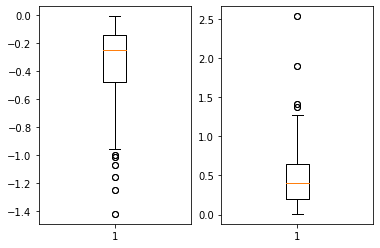

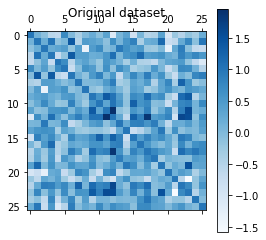

In [41]:
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Seeing if negative data have same order of magnitude as positive data 
def orderOfMAgnitude(matrix):
    for i in range(N):
        matrix[i,i] = 0
    neg = matrix[matrix<0]
    plt.subplot(121)
    plt.boxplot(neg)
    pos = matrix[matrix>0]
    plt.subplot(122)
    plt.boxplot(pos)

orderOfMAgnitude(np.copy(ISC_IBI))
    
N = len(ISC_EEG)

# Remove Inf in data
for i in range(N):
    ISC_IBI[i,i] = 1
    ISC_EDA[i,i] = 1

matrix = ISC_EDA    

plt.matshow(matrix, cmap=plt.cm.Blues)
plt.title("Original dataset")
plt.colorbar()
plt.show()

In [3]:
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
narrative = np.where(condition == 0)[0]
stimulus = np.where(condition == 1)[0]


In [4]:
# Transform matrix into correlation matrix
if ((matrix == ISC_EEG).all()):
    matrix_norm = np.copy(matrix) / 3
    matrix_cheat = np.copy(matrix)
    for i in range(len(matrix)):
        matrix_cheat[i,i] = 0.05
else:
    matrix_norm = np.copy(matrix)
    for i in range(len(matrix)):
        matrix_norm[i,i] = 1

# Normalise max value to 1
matrix_norm = matrix_norm / np.max(abs(matrix_norm))
        
# Compute distance matrix
matrix_dist = np.sqrt(2*N*(1-matrix_norm))

'''
# Normalise data
for i in range(len(matrix)):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
''' 

'\n# Normalise data\nfor i in range(len(matrix)):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

## Bloc modelling / Bi-clustering

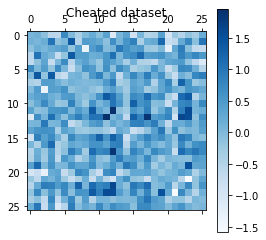

In [5]:
matrix_cheat = np.copy(matrix)
for i in range(len(matrix)):
    matrix_cheat[i,i] = 0.05
        
plt.matshow(matrix_cheat, cmap=plt.cm.Blues)
plt.title("Cheated dataset")
plt.colorbar()
plt.show()

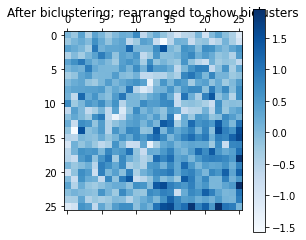

In [6]:
model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(matrix_cheat)
#score = consensus_score(model.biclusters_,
#                        (rows[:, row_idx], columns[:, col_idx]))

#print("consensus score: {:.3f}".format(score))

fit_data = matrix_cheat[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
plt.show()

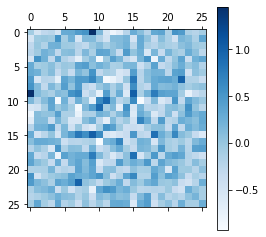

In [7]:
decorr = np.linalg.inv(matrix)

plt.matshow(decorr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## Hierarchical clustering

### Hierarchical clustering based on correlation (cheating on the diagonal)

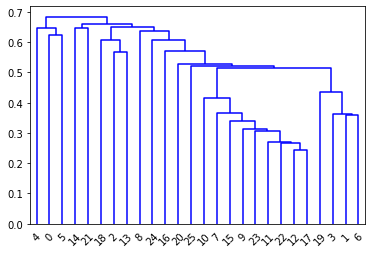

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage

for i in range(len(matrix)):
    matrix_cheat[i,i] = 3
    
matrix_norm = matrix_cheat / 3
Z=linkage(matrix_norm, 'single', 'correlation')
dendrogram(Z, color_threshold=0)
plt.show()

### Hierarchical clustering based on euclidean distance

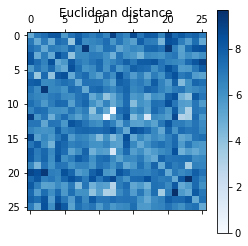

In [9]:
plt.matshow(matrix_dist, cmap=plt.cm.Blues)
plt.title("Euclidean distance")
plt.colorbar()
plt.show()

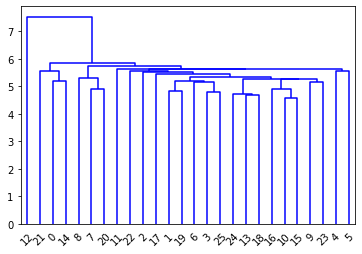

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z=linkage(matrix_dist, 'single', 'euclidean')
dendrogram(Z, color_threshold=0)
plt.show()

In [11]:
print("group 0 : ",narrative)
print("group 1 : ",stimulus)

group 0 :  [ 0  2  4  5  7  9 11 13 16 17 18 22 25]
group 1 :  [ 1  3  6  8 10 12 14 15 19 20 21 23 24]


## Multi Dimensionnal Scaling

In [22]:
from sklearn import manifold

def computeMDSCoordinate(n_comp):
    mds = manifold.MDS(n_components=n_comp,random_state=1)
    mds.fit(matrix_dist)
    points = mds.embedding_
    stress = mds.stress_
    print("Stress of the method : %f" %stress)

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    return points

//anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Stress of the method : 1189.648553


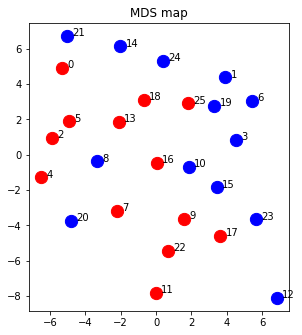

In [27]:
from sklearn.decomposition import PCA

def transformPoints(points):
    pca = PCA(n_components=2)
    return pca.fit_transform(points)
    print("%f variance explained when plotting" %sum(pca.explained_variance_ratio_[:2]))

def plotMdsPoints(points):
    ax = plt.axes([1.2,0,1,1])
    ax.set_aspect(aspect='equal')

    #points = transformPoints(points)
    
    for i in range(len(condition)):
        if (condition[i] == 0):
            color = 'blue'
        else:
            color = 'red'
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+0.3,points[i,1]))

    plt.scatter(points[narrative,0],points[narrative,1],color='red',s=150)
    plt.scatter(points[stimulus,0],points[stimulus,1],color='blue',s=150)
    
    plt.title('MDS map')
    plt.show()
    
points = computeMDSCoordinate(2)
plotMdsPoints(points)

## DBSCAN (here for precomputed metric -> array of distances)

In [28]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=2.97, min_samples=3,metric='precomputed').fit(matrix_dist)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


NameError: name 'color' is not defined

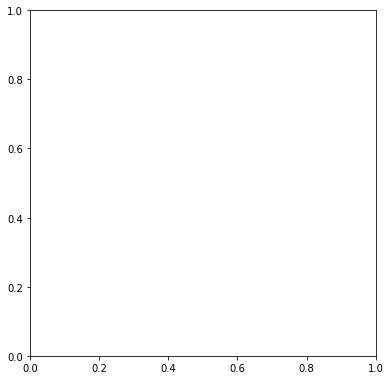

In [29]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = points[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14,color=color)

    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6,color=color)

plt.title('Estimated number of clusters: %d' % n_clusters_)

points = computeMDSCoordinate(2)
plotMdsPoints(points)

plt.show()

## Mean Shift (to do on coordinates)

//anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Stress of the method : 1189.648553
number of estimated clusters : 6


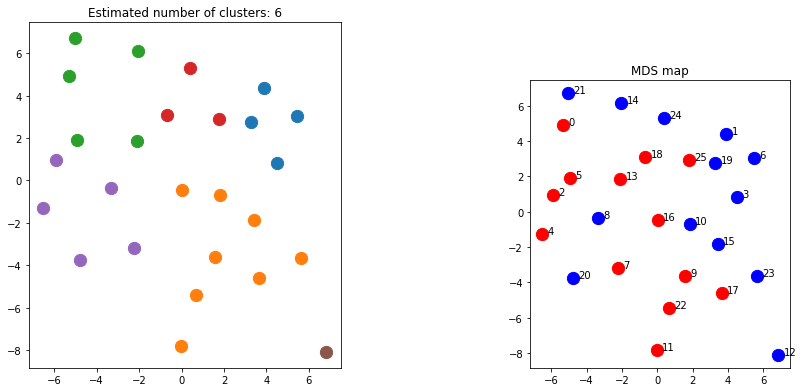

In [30]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift
points = computeMDSCoordinate(2) # Look only at 2 3 or 4D, then bad results

# The following ban*dwidth can be automatically detected using
bandwidth = estimate_bandwidth(points, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
from itertools import cycle

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
#points = transformPoints(points)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(points[my_members, 0], points[my_members, 1], s=150)
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)

plotMdsPoints(points)

plt.show()

## Spectral clustering (on coordinates)

In [ ]:
from sklearn.cluster import SpectralClustering

max_prec = 0

for i in range(1,N):
    points = computeMDSCoordinate(i)
    
    #Spectral clustering
    clustering = SpectralClustering(n_clusters=2,
                assign_labels="discretize",
                random_state=0).fit(points)
    if sum(condition==clustering.labels_)/N > max_prec:
        max_prec = sum(condition==clustering.labels_)/N
        label = clustering.labels_
    
print(label)
print(condition)
print(sum(condition==label)/N)